
Problem 1: Implementing Naive BlackJack as a Gym Environment (25 points)

In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
import os
import time
import random

import math
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from itertools import product
from tqdm import tqdm
import json

In [3]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


In [4]:
class NaiveBlackjackEnv(gym.Env):
    def __init__(self):
      super(NaiveBlackjackEnv, self).__init__()
      self.observation_space = spaces.Tuple(
                                (spaces.Discrete(32), # P: total value of the player’s hand # 32?
                                  spaces.Discrete(2), # A: binary variable, whether player has an active Ace
                                  spaces.Discrete(11)  # D: Dealer's Visible card (1 to 10, where 1 is Ace)
                                  ))
      self.action_space = gym.spaces.Discrete(2) # 0: Stand, 1: Hit 
      # Card deck (ignoring suits)
      self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]  # Ace card represents as 1
      self.reset()

    def reset(self):
        # super().reset(seed=42)
        card1 = np.random.choice(self.deck)
        self.player_total = card1
        self.player_ace = int(card1 == 1)  # Check if an Ace is counted as 11
        self.dealer_card = np.random.choice(self.deck)
        self.done = False
        return self._get_obs()

    def _get_obs(self):
      return (self.player_total, self.player_ace, self.dealer_card)

    def step(self, action):
      if self.done:
        return self._get_obs(), 0, True, {}
      if action == 1:
        new_card = np.random.choice(self.deck)
        if new_card == 1 and self.player_ace ==0 and self.player_total <= 10 :
          self.player_total += 11
          self.player_ace = 1
        else:
          self.player_total += new_card

        if self.player_total > 21 and self.player_ace == 1:
          self.player_total -= 10
          self.player_ace = 0
        if self.player_total > 21 and self.player_ace == 0:
          self.done = True
          # return new state, reward, terminal status
          # if player bust, return =-1
          return self._get_obs(), -1, self.done, {} 
        # continue the game
        return self._get_obs(), 0, self.done, {}
      else:
        dealer_total = self.dealer_card + np.random.choice(self.deck)
        while dealer_total < 17:
          dealer_total += np.random.choice(self.deck)
          if dealer_total > 21:
            # Dealer bust, player didn't player earn reward 1
            return self._get_obs(), 1, True, {} 
        self.done = True
        # neither bust
        if self.player_total > dealer_total:
          return self._get_obs(), 1, self.done, {}
        else:
          return self._get_obs(), -1, self.done, {}

In [5]:
env = NaiveBlackjackEnv()

n_episodes = 1000
total_reward = 0

for _ in range(n_episodes):
    state = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # Random action
        state, reward, done, _ = env.step(action)
        total_reward += reward

avg_reward = total_reward / n_episodes
print(f"Average Reward over {n_episodes} episodes: {avg_reward}")

Average Reward over 1000 episodes: -0.39


Problem 2: Implementing DQN Variants (25 points)
In this problem, you will implement and compare three DQN variants:  
1. Naive DQN (provided in the last code block in Lecture 6 Colab).  
2. Double DQN.
3. Multi-step Return DQN.

Answer for Problem 2 (Also for Problem 3): Since each algorithm takes long time to generate reward history, create figure; I didn't execute them in a single jupyternotebook. I'll paste the code below, and show the figure and results from what I saved in folder (after real execuation)

In [6]:
# Naive DQN
NUM_LAYERS = [2, 3, 4]  # Number of layers in the network
NUM_NEURONS = [64, 128, 256]  # Number of neurons per layer
BATCH_SIZE = [128, 256, 512]  # Batch size
LEARNING_RATE = [1e-3, 1e-4, 1e-5]  # Learning rate
DISCOUNT_FACTOR = [0.9, 0.95, 0.99]  # Discount factor
MULTI_STEP = [3, 5, 10]  # Number of steps for multi-step returns
EPSILON_DECAY = [0.99, 0.995, 0.999]  # Exploration decay rate

# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, num_layers, num_neurons):
        super(QNetwork, self).__init__()
        layers = []
        input_dim = state_size
        for _ in range(num_layers):
            layers.append(nn.Linear(input_dim, num_neurons))
            layers.append(nn.ReLU())
            input_dim = num_neurons
        layers.append(nn.Linear(input_dim, action_size))
        self.model = nn.Sequential(*layers)
    
    def forward(self, state):
        return self.model(state)

# DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size, num_layers, num_neurons, lr, gamma, batch_size, target_update, epsilon_decay):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.01
        self.target_update = target_update
        
        self.memory = deque(maxlen=10000)
        
        self.q_network = QNetwork(state_size, action_size, num_layers, num_neurons).to(device)
        self.target_network = QNetwork(state_size, action_size, num_layers, num_neurons).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
    
    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.choice(range(self.action_size))
        state = torch.FloatTensor(state).to(device).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.q_network(state)).item()
    
    def store_transition(self, transition):
        self.memory.append(transition)  # 直接存储 transition，不用 multi-step buffer

    def train(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            max_next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values  # 1-step return

        loss = self.criterion(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

# Train and Evaluate
def moving_average(data, window_size=100):
    if len(data) < window_size:
        return np.mean(data)
    return np.mean(data[-window_size:])

def train_dqn(agent, env, episodes):
    rewards = []
    smoothed_rewards = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        step_count = 0
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.store_transition((state, action, reward, next_state, done))
            agent.train()
            state = next_state
            total_reward += reward
            step_count += 1
        per_step_avg_reward = total_reward / step_count
        
        if episode % agent.target_update == 0:
            agent.update_target_network()
        
        rewards.append(per_step_avg_reward)
        smoothed_rewards.append(moving_average(rewards, window_size=100))

        if episode % 5000 == 0:
            print(f"Episode {episode}, Avg Step Reward: {per_step_avg_reward}, Moving Avg Reward: {smoothed_rewards[-1]:.4f}, Epsilon: {agent.epsilon:.4f}")
    return rewards, smoothed_rewards


In [7]:
best_params = {
    "num_layers": random.choice(NUM_LAYERS),
    "num_neurons": random.choice(NUM_NEURONS),
    "batch_size": random.choice(BATCH_SIZE),
    "lr": random.choice(LEARNING_RATE),
    "gamma": random.choice(DISCOUNT_FACTOR),
    # "multi_step": random.choice(MULTI_STEP),
    "epsilon_decay": random.choice(EPSILON_DECAY),
}

best_auc = -np.inf
best_reward = -np.inf

env = NaiveBlackjackEnv()
state_size = len(env.observation_space)
action_size = env.action_space.n

In [ ]:
num_iterations = 5
for iteration in tqdm(range(num_iterations), desc = "Coordinate Descent Hyperparameters tuning", total = num_iterations):
   print(f"\n===== Coordinate Descent Iteration {iteration + 1} =====")
   for param_name, param_values in tqdm([
        ("num_layers", NUM_LAYERS),
        ("num_neurons", NUM_NEURONS),
        ("batch_size", BATCH_SIZE),
        ("lr", LEARNING_RATE),
        ("gamma", DISCOUNT_FACTOR),
        # ("multi_step", MULTI_STEP),
        ("epsilon_decay", EPSILON_DECAY),
    ], desc = "Optimizing Hyperparameter", total = 6):
        print(f"Optimizing {param_name}...")

        for param_value in tqdm(param_values, desc=f"Tuning {param_name}"):
            # Test current params
            temp_params = best_params.copy()
            temp_params[param_name] = param_value

            # Train new model
            agent = DQNAgent(
                state_size, action_size, 
                temp_params["num_layers"], temp_params["num_neurons"], 
                temp_params["lr"], temp_params["gamma"], temp_params["batch_size"], 
                10, temp_params["epsilon_decay"]
            )
            rewards, smoothed_rewards = train_dqn(agent, env, 10000)  
            auc = np.trapz(smoothed_rewards)

            if auc > best_auc:
                best_agent = agent
                best_rewards = rewards
                best_smoothed_rewards = smoothed_rewards
                best_params[param_name] = param_value
                best_auc = auc
                print(f"Updated best {param_name} -> {param_value} (AUC: {best_auc})")

# Plot rewards
save_figure_path = "./HW_figure"
save_result_path = "./results"

plt.plot(best_smoothed_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Double DQN Best Episodes reward')

plt.savefig(os.path.join(save_figure_path,'Naive_DQN_best_dqn_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

results_dict = {
    "best_avg_step_reward": np.mean(best_reward),
    "best_avg_smoothed_reward": np.mean(best_smoothed_rewards),
    "reward_list": best_reward,  
    "smoothed_reward_list": best_smoothed_rewards,  
    "auc": best_auc,
    "best_parameters": best_params
}
print("Save element in json!")

result_file = os.path.join(save_result_path,"naive_dqn_results.txt")
with open(result_file, "w") as f:
    json.dump(results_dict, f, indent = 4)
print(f"Results saved in {result_file}")

In [8]:
%cd /projectnb/vkolagrp/yiliu/hrandomw
def get_json(path_name, algo_name):
    with open(f"./results/{path_name}_results.txt", "r", encoding="utf-8") as f:
        data = json.load(f)
    best_avg_smoothed_reward = data['best_avg_smoothed_reward']
    smoothed_rewards = data['smoothed_reward_list']
    auc = data['auc']
    best_params = data["best_parameters"]
    print(f"The best avg smoothed reward is {best_avg_smoothed_reward}. \n The AUC for {algo_name} is {auc} \n under parameters {best_params}")
    return auc, smoothed_rewards

naive_dqn_auc, naive_dqn_rewards = get_json("naive_dqn", "Naive DQN")

/projectnb/vkolagrp/yiliu/hrandomw
The best avg smoothed reward is -0.05855096052063448. 
 The AUC for Naive DQN is -585.2384861587257 
 under parameters {'num_layers': 4, 'num_neurons': 256, 'batch_size': 256, 'lr': 0.0001, 'gamma': 0.95, 'epsilon_decay': 0.99}


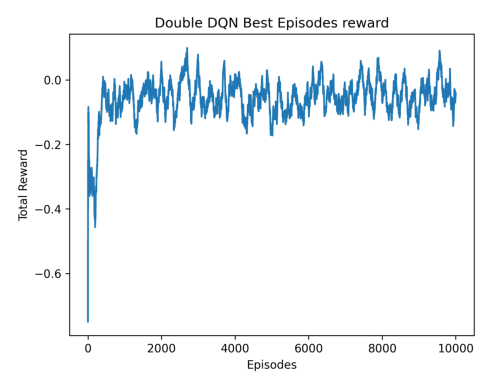

In [9]:
from PIL import Image
def get_image(image_path):
    image = Image.open(f"./HW_figure/{image_path}.png")
    plt.imshow(image)
    plt.axis("off")  
    plt.show()

image_path = "Naive_DQN_best_dqn_performance"
get_image(image_path)

In [10]:
# Double DQN
NUM_LAYERS = [2, 3, 4]  # Number of layers in the network
NUM_NEURONS = [64, 128, 256]  # Number of neurons per layer
BATCH_SIZE = [128, 256, 512]  # Batch size
LEARNING_RATE = [1e-3, 1e-4, 1e-5]  # Learning rate
DISCOUNT_FACTOR = [0.9, 0.95, 0.99]  # Discount factor
EPSILON_DECAY = [0.99, 0.995, 0.999]  # Exploration decay rate

# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, num_layers, num_neurons):
        super(QNetwork, self).__init__()
        layers = []
        input_dim = state_size
        for _ in range(num_layers):
            layers.append(nn.Linear(input_dim, num_neurons))
            layers.append(nn.ReLU())
            input_dim = num_neurons
        layers.append(nn.Linear(input_dim, action_size))
        self.model = nn.Sequential(*layers)
    
    def forward(self, state):
        return self.model(state)

# DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size, num_layers, num_neurons, lr, gamma, batch_size, target_update, epsilon_decay): #, multi_step):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.01
        self.target_update = target_update
        # self.multi_step = multi_step
        self.memory = deque(maxlen=10000)
        # self.n_step_buffer = deque(maxlen=multi_step)
        
        self.q_network = QNetwork(state_size, action_size, num_layers, num_neurons).to(device)
        self.target_network = QNetwork(state_size, action_size, num_layers, num_neurons).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
    
    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.choice(range(self.action_size))
        state = torch.FloatTensor(state).to(device).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.q_network(state)).item()
    
    def store_transition(self, transition):
        self.memory.append(transition) 

    ## REVISE: use self.q_network to pick best action; use self.target_network to calculate targetd Q value
    def train(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            # Double DQN - select action using online Q-network
            next_actions = self.q_network(next_states).argmax(1)
            # Get target Q-value from target network
            max_next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

        loss = self.criterion(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

# Train and Evaluate
def moving_average(data, window_size=100):
    if len(data) < window_size:
        return np.mean(data)
    return np.mean(data[-window_size:])

def train_dqn(agent, env, episodes):
    rewards = []
    smoothed_rewards = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        step_count = 0
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.store_transition((state, action, reward, next_state, done))
            agent.train()
            state = next_state
            total_reward += reward
            step_count += 1
        
        per_step_avg_reward = total_reward / step_count

        if episode % agent.target_update == 0:
            agent.update_target_network()
      
        rewards.append(per_step_avg_reward)
        smoothed_rewards.append(moving_average(rewards, window_size=100))

        if episode % 100 == 0:
            print(f"Episode {episode}, Avg Step Reward: {per_step_avg_reward},Moving Avg Reward: {smoothed_rewards[-1]:.4f}, Epsilon: {agent.epsilon:.4f}")
    return rewards, smoothed_rewards

In [ ]:
best_params = {
    "num_layers": random.choice(NUM_LAYERS),
    "num_neurons": random.choice(NUM_NEURONS),
    "batch_size": random.choice(BATCH_SIZE),
    "lr": random.choice(LEARNING_RATE),
    "gamma": random.choice(DISCOUNT_FACTOR),
    "epsilon_decay": random.choice(EPSILON_DECAY),
}
best_agent = None
best_auc = -np.inf
best_reward = -np.inf

env = NaiveBlackjackEnv()
state_size = len(env.observation_space)
action_size = env.action_space.n

num_iterations = 5
for iteration in tqdm(range(num_iterations), desc = "Coordinate Descent Hyperparameters tuning", total = num_iterations):
   print(f"\n===== Coordinate Descent Iteration {iteration + 1} =====")
   for param_name, param_values in tqdm([
        ("num_layers", NUM_LAYERS),
        ("num_neurons", NUM_NEURONS),
        ("batch_size", BATCH_SIZE),
        ("lr", LEARNING_RATE),
        ("gamma", DISCOUNT_FACTOR),
        # ("multi_step", MULTI_STEP),
        ("epsilon_decay", EPSILON_DECAY),
    ], desc = "Optimizing Hyperparameter", total = 6):
        print(f"Optimizing {param_name}...")

        for param_value in tqdm(param_values, desc=f"Tuning {param_name}"):
            # Test current params
            temp_params = best_params.copy()
            temp_params[param_name] = param_value

            # Train new model
            agent = DQNAgent(
                state_size, action_size, 
                temp_params["num_layers"], temp_params["num_neurons"], 
                temp_params["lr"], temp_params["gamma"], temp_params["batch_size"], 
                10, temp_params["epsilon_decay"]
            )
            rewards, smoothed_rewards = train_dqn(agent, env, 10000)  
            auc = np.trapz(smoothed_rewards)

            if auc > best_auc:
                best_agent = agent
                best_rewards = rewards
                best_smoothed_rewards = smoothed_rewards
                best_params[param_name] = param_value
                best_auc = auc
                print(f"Updated best {param_name} -> {param_value} (AUC: {best_auc})")

# Plot rewards
save_figure_path = "./HW_figure"
save_result_path = "./results"

plt.plot(best_smoothed_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Double DQN Best Episodes reward')

plt.savefig(os.path.join(save_figure_path,'Double_DQN_best_dqn_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

results_dict = {
    "best_avg_step_reward": np.mean(best_reward),
    "best_avg_smoothed_reward": np.mean(best_smoothed_rewards),
    "reward_list": best_reward,  
    "smoothed_reward_list": best_smoothed_rewards,  
    "auc": best_auc,
    "best_parameters": best_params
}
print("Save element in json!")

result_file = os.path.join(save_result_path,"double_dqn_results.txt")
with open(result_file, "w") as f:
    json.dump(results_dict, f, indent = 4)
print(f"Results saved in {result_file}")

In [12]:
# Results for Double DQN
double_dqn_auc, double_dqn_rewards = get_json("double_dqn", "Double DQN")

The best avg smoothed reward is -0.05849454319209305. 
 The AUC for Double DQN is -584.4074319209307 
 under parameters {'num_layers': 4, 'num_neurons': 256, 'batch_size': 128, 'lr': 1e-05, 'gamma': 0.95, 'epsilon_decay': 0.995}


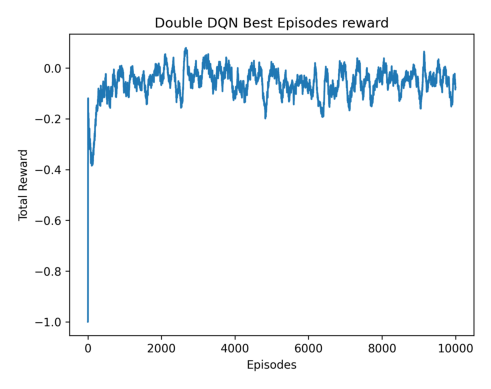

In [13]:
get_image('Double_DQN_best_dqn_performance')

In [17]:
# Multistep_Return DQN
NUM_LAYERS = [2, 3, 4]  # Number of layers in the network
NUM_NEURONS = [64, 128, 256]  # Number of neurons per layer
BATCH_SIZE = [128, 256, 512]  # Batch size
LEARNING_RATE = [1e-3, 1e-4, 1e-5]  # Learning rate
DISCOUNT_FACTOR = [0.9, 0.95, 0.99]  # Discount factor
MULTI_STEP = [3, 5, 10]  # Number of steps for multi-step returns
EPSILON_DECAY = [0.99, 0.995, 0.999] 

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, num_layers, num_neurons):
        super(QNetwork, self).__init__()
        layers = []
        input_dim = state_size
        for _ in range(num_layers):
            layers.append(nn.Linear(input_dim, num_neurons))
            layers.append(nn.ReLU())
            input_dim = num_neurons
        layers.append(nn.Linear(input_dim, action_size))
        self.model = nn.Sequential(*layers)
    
    def forward(self, state):
        return self.model(state)

# DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size, num_layers, num_neurons, lr, gamma, batch_size, target_update, epsilon_decay, multi_step):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.01
        self.target_update = target_update
        self.multi_step = multi_step
        self.memory = deque(maxlen=10000)
        self.n_step_buffer = deque(maxlen=multi_step)
        
        self.q_network = QNetwork(state_size, action_size, num_layers, num_neurons).to(device)
        self.target_network = QNetwork(state_size, action_size, num_layers, num_neurons).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
    
    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.choice(range(self.action_size))
        state = torch.FloatTensor(state).to(device).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.q_network(state)).item()
    
    def store_transition(self, transition):
        self.n_step_buffer.append(transition)
        if len(self.n_step_buffer) == self.multi_step:
            state, action, reward, next_state, done = self.n_step_buffer[0]
            for i in range(1, self.multi_step):
                reward += (self.gamma ** i) * self.n_step_buffer[i][2]
                next_state = self.n_step_buffer[i][3]
                done = self.n_step_buffer[i][4]
            self.memory.append((state, action, reward, next_state, done))
    
    def train(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)
        
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            max_next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * (self.gamma ** self.multi_step) * max_next_q_values # multi-step return
        
        loss = self.criterion(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

# Train and Evaluate
# Simple Moving Average
def moving_average(data, window_size=100):
    if len(data) < window_size:
        return np.mean(data)
    return np.mean(data[-window_size:])

def train_dqn(agent, env, episodes):
    rewards = []
    smoothed_rewards = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        step_count = 0
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.store_transition((state, action, reward, next_state, done))
            agent.train()
            state = next_state
            total_reward += reward
            step_count += 1
        
        per_step_avg_reward = total_reward / step_count if step_count> 0 else 0
        
        if episode % agent.target_update == 0:
            agent.update_target_network()
        
        rewards.append(per_step_avg_reward)
        smoothed_rewards.append(moving_average(rewards, window_size=100))

        if episode % 1000 == 0:
            print(f"Episode {episode}, Avg Reward: {per_step_avg_reward}, Moving Avg Reward: {smoothed_rewards[-1]:.4f}, Epsilon: {agent.epsilon:.4f}")
    return rewards, smoothed_rewards


In [ ]:
best_params = {
    "num_layers": random.choice(NUM_LAYERS),
    "num_neurons": random.choice(NUM_NEURONS),
    "batch_size": random.choice(BATCH_SIZE),
    "lr": random.choice(LEARNING_RATE),
    "gamma": random.choice(DISCOUNT_FACTOR),
    "multi_step": random.choice(MULTI_STEP),
    "epsilon_decay": random.choice(EPSILON_DECAY),
}
best_agent = None
best_auc = -np.inf
best_reward = -np.inf

env = NaiveBlackjackEnv()
state_size = len(env.observation_space)
action_size = env.action_space.n

num_iterations = 5
for iteration in tqdm(range(num_iterations), desc = "Coordinate Descent Hyperparameters tuning", total = num_iterations):
   print(f"\n===== Coordinate Descent Iteration {iteration + 1} =====")
   for param_name, param_values in tqdm([
        ("num_layers", NUM_LAYERS),
        ("num_neurons", NUM_NEURONS),
        ("batch_size", BATCH_SIZE),
        ("lr", LEARNING_RATE),
        ("gamma", DISCOUNT_FACTOR),
        ("multi_step", MULTI_STEP),
        ("epsilon_decay", EPSILON_DECAY),
    ], desc = "Optimizing Hyperparameter", total = 7):
        print(f"Optimizing {param_name}...")

        for param_value in tqdm(param_values, desc=f"Tuning {param_name}"):
            # Test current params
            temp_params = best_params.copy()
            temp_params[param_name] = param_value

            # Train new model
            agent = DQNAgent(
                state_size, action_size, 
                temp_params["num_layers"], temp_params["num_neurons"], 
                temp_params["lr"], temp_params["gamma"], temp_params["batch_size"], 
                10, temp_params["epsilon_decay"], temp_params["multi_step"]
            )
            rewards, smoothed_rewards = train_dqn(agent, env, 10000)  
            auc = np.trapz(rewards)

            if auc > best_auc:
                best_agent = agent
                best_rewards = rewards
                best_smoothed_rewards = smoothed_rewards
                best_params[param_name] = param_value
                best_auc = auc
                print(f"Updated best {param_name} -> {param_value} (AUC: {best_auc})")

# Plot rewards
save_figure_path = "./HW_figure"
save_result_path = "./results"

plt.plot(best_smoothed_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Multistep Return DQN Best Episodes reward')

plt.savefig(os.path.join(save_figure_path,'Multistep_return_best_dqn_performance.png'), dpi=300, bbox_inches='tight')
plt.show()

results_dict = {
    "best_avg_step_reward": np.mean(best_reward),
    "best_avg_smoothed_reward": np.mean(best_smoothed_rewards),
    "reward_list": best_reward,  
    "smoothed_reward_list": best_smoothed_rewards,  
    "auc": best_auc,
    "best_parameters": best_params
}
print("Save element in json!")

result_file = os.path.join(save_result_path,"multistep_return_results.txt")
with open(result_file, "w") as f:
    json.dump(results_dict, f, indent = 4)
print(f"Results saved in {result_file}")

In [14]:
# Result for Multistep_return DQN
multistep_return_dqn_auc, multistep_return_dqn_rewards = get_json("multistep_return", "Multistep Return DQN")


The best avg smoothed reward is -0.06372139806040229. 
 The AUC for Multistep Return DQN is -627.304365079365 
 under parameters {'num_layers': 2, 'num_neurons': 256, 'batch_size': 256, 'lr': 1e-05, 'gamma': 0.95, 'multi_step': 3, 'epsilon_decay': 0.99}


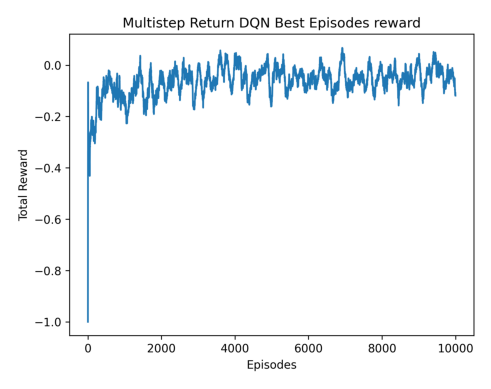

In [15]:
get_image('Multistep_return_best_dqn_performance')

Problem 3: Implementing Policy Gradient Methods (25 points) 
In this problem, you will implement and compare three policy gradient methods: 
1. REINFORCE. 
2. Trust Region Policy Optimization (TRPO). 
3. Proximal Policy Optimization (PPO). 

In [20]:
# REINFORCE 
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.embedding1 = nn.Embedding(32, 16)  # First element: 32 possible values → 16-dim embedding
        self.embedding2 = nn.Embedding(5, 8)    # Second element: 5 possible values → 8-dim embedding
        self.embedding3 = nn.Embedding(32, 16) 

        self.affine1 = nn.Linear(3, 128)
        # self.affine1 = nn.Linear(3, 128)
        self.dropout = nn.Dropout(p=0.6)
        self.affine2 = nn.Linear(128, 2)
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x1 = self.affine1(x)
        x2 = self.dropout(x1)
        x3 = F.relu(x2)

        action_scores = self.affine2(x3)
        return F.softmax(action_scores, dim=1)

    def select_action(self, state):
        # state 传入policy network 得到action prob 分布
        state = torch.from_numpy(state).float().unsqueeze(0).to('cuda:1')
        probs = self.forward(state)
        entropy_bonus = -0.01 * (probs * probs.log()).sum()
        m = Categorical(probs)
        # sample one action
        action = m.sample()
        self.saved_log_probs.append(m.log_prob(action))
        return action.item()

    def finish_episode(self, policy, optimizer, gamma, eps = np.finfo(np.float32).eps.item()):
        R = 0
        policy_loss = []
        returns = deque()
        # print("policy.rewards before calling finish_episode:", policy.rewards)
        for r in policy.rewards[::-1]:  # policy_rewards[::-1]:
            R = r + gamma * R
            returns.appendleft(R)
        returns = torch.tensor(returns, dtype = torch.float32, device = 'cuda:1')
        
        if returns.std() == 0 or torch.isnan(returns.std()):
            returns = returns - returns.mean()
        else: 
            # returns = (returns - returns.mean()) / (returns.std() + eps)
            returns = (returns - returns.mean()) / (returns.std().clamp(min=eps))
        
        entropy_bonus = 0.0
        for log_prob, R in zip(policy.saved_log_probs, returns):
            entropy_bonus += 0.01 * (-log_prob.exp() * log_prob).sum()
            # print(f"log_prob: {log_prob.item()}, R: {R.item()}, log_prob * R: {(-log_prob * R).item()}")
            policy_loss.append(-log_prob * R + entropy_bonus)

        # print(f"policy_loss length: ", len(policy_loss))
        optimizer.zero_grad()
        if len(policy_loss) > 0:
            policy_loss = torch.cat(policy_loss).sum() * 10
        else:
            policy_loss = torch.tensor(0.0, device='cuda:1')
        # print(f"Policy loss: {policy_loss.item()}")
        policy_loss.backward()
        

        # for name, param in policy.named_parameters():
        #   if param.grad is not None:
        #       print(f"{name} gradient mean: {param.grad.mean().item()}")
        torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=0.5)
        optimizer.step()

        del policy.rewards[:]
        del policy.saved_log_probs[:]

In [21]:
def training_loop(lr, gamma):
    policy = Policy().to('cuda:1')
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    
    smoothed_reward = 0
    ep_rewards = []
    smoothed_rewards = []
    # param_grads = []

    for i_episode in tqdm(range(10000), desc = "Processing episode"):
        state = env.reset(seed=42)
        state = torch.tensor(state, dtype=torch.float32, device='cuda:1')

        ep_reward = 0
        done = False
        while not done:  # Don't infinite loop while learning
            action = policy.select_action(state.cpu().numpy())
            state, reward, done, _ = env.step(action)
            state = torch.tensor(state, dtype=torch.float32, device='cuda:1')
            reward = torch.tensor(reward, dtype=torch.float32, device='cuda:1')
            # env.render()
            policy.rewards.append(reward)
            ep_reward += reward
            if done:
                break
        # print("Reward list ", policy.rewards)
        # print("Ep_reward for one round: ", ep_reward)
        ep_rewards.append(ep_reward)
        smoothed_reward = 0.05 * ep_reward + (1-0.05) * smoothed_reward
        # print("Smoothed_reward: ", smoothed_reward)
        smoothed_rewards.append(smoothed_reward)
        # print("Reward list ", policy.rewards)
        policy.finish_episode(policy, optimizer, gamma)
        # param_grads.append(param_grad)

    # smoothed_rewards = smoothed_rewards.cpu().numpy() 
    smoothed_rewards = [item.cpu().numpy() if isinstance(item, torch.Tensor) else item for item in smoothed_rewards]
    # check device for smoothed_rewards
    for i, item in enumerate(smoothed_rewards):
      if isinstance(item, torch.Tensor):
        if item.device.type != 'cpu':
          print(f"Element {i} is a Tensor on {item.device}")
          break

    AUC = auc(range(len(smoothed_rewards)), smoothed_rewards)
    print("The avg smoothed_reward per episod is ", round(np.mean(smoothed_rewards),2), " and the AUC is ", round(AUC,2))
    # plot_smoothed_reward_espisod(smoothed_rewards)
    
    return AUC, smoothed_rewards

In [ ]:
env = NaiveBlackjackEnv()
env.reset(seed = 42)

LEARNING_RATE = [1e-3, 1e-4, 1e-5]
BATCH_SIZE = [128, 256, 512]
DISCOUNT_FACTOR = [0.9, 0.95, 0.99]

best_params = {
    "batch_size": random.choice(BATCH_SIZE),
    "lr": random.choice(LEARNING_RATE),
    "gamma": random.choice(DISCOUNT_FACTOR),
}
best_auc = -np.inf

num_iterations = 5
for iteration in tqdm(range(num_iterations), desc = "Coordinate Descent Hyperparameters tuning", total = num_iterations):
   print(f"\n===== Coordinate Descent Iteration {iteration + 1} =====")
   for param_name, param_values in tqdm([
        ("batch_size", BATCH_SIZE),
        ("lr", LEARNING_RATE),
        ("gamma", DISCOUNT_FACTOR),
    ], desc = "Optimizing Hyperparameter", total = 6):
        print(f"Optimizing {param_name}...")

        for param_value in tqdm(param_values, desc=f"Tuning {param_name}"):
            # Test current params
            temp_params = best_params.copy()
            temp_params[param_name] = param_value

            if param_name == "batch_size":
                temp_params["lr"] = best_params["lr"] * (param_value / best_params["batch_size"])

            AUC, smoothed_rewards = training_loop(temp_params['lr'], temp_params['gamma'])

            if AUC > best_auc: 
                smoothed_rewards_list = smoothed_rewards
                best_params[param_name] = param_value
                best_auc = AUC
                print(f"Updated best {param_name} -> {param_value} (AUC: {best_auc})")

save_figure_path = "./HW_figure"
save_result_path = "./results"

smoothed_rewards_list = [float(r) for r in smoothed_rewards_list]
plt.plot(smoothed_rewards_list)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('REINFORCE Episodes reward')

plt.savefig(os.path.join(save_figure_path,'REINFORCE_performance.png'), dpi=300, bbox_inches='tight')
# plt.show()

results_dict = {
    "best_avg_smoothed_reward": round(np.mean(smoothed_rewards_list),4),
    "smoothed_reward_list": smoothed_rewards_list,
    "auc": round(float(best_auc),4), 
    "best_parameters": best_params
}
print("Save element in json!")
result_file = os.path.join(save_result_path,"REINFORCE_results.txt")
with open(result_file, "w") as f:
    json.dump(results_dict, f, indent = 4)
print(f"Results saved in {result_file}")

In [16]:
REINFORCE_auc, REINFORCE_rewards = get_json("REINFORCE", "REINFORCE")

The best avg smoothed reward is -0.247. 
 The AUC for REINFORCE is -2469.9797 
 under parameters {'batch_size': 512, 'lr': 0.001, 'gamma': 0.9}


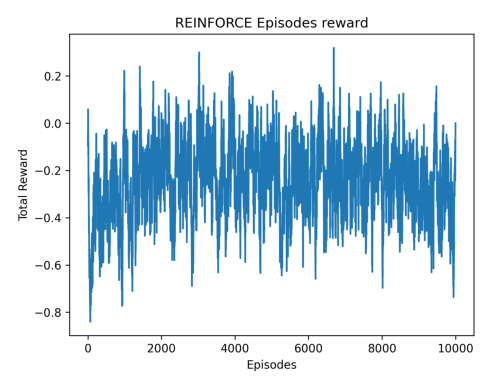

In [17]:
get_image("REINFORCE_performance")
# The grad exploded due to close-to-zero return and close-to-zero probs

In [69]:
# TRPO
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(3, 128)
        self.affine2 = nn.Linear(128, 2)
        self.saved_log_probs = []
        self.rewards = []
    
    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)
    
    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to('cuda:3')
        probs = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        self.saved_log_probs.append(m.log_prob(action))
        return action.item()

def conjugate_gradient(Ax, b, tol=1e-10, max_steps=10):
    x = torch.zeros_like(b)
    r = b.clone()
    p = b.clone()
    rdotr = torch.dot(r, r)
    print("p: ", p)
    for i in range(max_steps):
        Ap = Ax(p)
        alpha = rdotr / torch.dot(p, Ap)
        x += alpha * p
        r -= alpha * Ap
        new_rdotr = torch.dot(r, r)
        if new_rdotr < tol:
            break
        beta = new_rdotr / rdotr
        p = r + beta * p
        rdotr = new_rdotr
    return x

def fisher_vector_product(policy, states, p):
    kl = compute_kl(policy, states)
    kl_grad = torch.autograd.grad(kl, policy.parameters(), create_graph=True)
    kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])
    klp = (kl_grad_vector * p).sum()
    klp_grad = torch.autograd.grad(klp, policy.parameters())
    return torch.cat([grad.contiguous().view(-1) for grad in klp_grad])

def compute_kl(policy, states):
    old_probs = policy.forward(states).detach()
    new_probs = policy.forward(states)
    kl = (old_probs * (torch.log(old_probs) - torch.log(new_probs))).sum(dim=1).mean()
    return kl

def trpo_update(policy, optimizer, states, actions, returns, damping=0.1, max_kl=0.01):
    probs = policy.forward(states)
    m = Categorical(probs)
    log_probs = m.log_prob(actions)
    
    loss = -torch.mean(log_probs * returns)
    
    grads = torch.autograd.grad(loss, policy.parameters(), create_graph=True)
    grads_vector = torch.cat([grad.view(-1) for grad in grads])
    
    def Ax(p):
        return fisher_vector_product(policy, states, p) + damping * p
    
    stepdir = conjugate_gradient(Ax, grads_vector)
    
    shs = 0.5 * torch.dot(stepdir, Ax(stepdir).clone())
    step_size = torch.sqrt(2 * max_kl / (shs + 1e-8))
    
    new_params = torch.cat([p.view(-1) for p in policy.parameters()]) + step_size * stepdir
    
    offset = 0
    with torch.no_grad():
        for param in policy.parameters():
            param.copy_(new_params[offset:offset + param.numel()].view(param.size()))
            offset += param.numel()

def training_loop(lr, gamma):
    policy = Policy().to('cuda:3')
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    
    smoothed_reward = 0
    ep_rewards = []
    smoothed_rewards = []
    
    for i_episode in range(10000):
        state = env.reset(seed=42)
        state = torch.tensor(state, dtype=torch.float32, device='cuda:3')

        ep_reward = 0
        done = False
        states, actions, rewards = [], [], []
        
        while not done:
            action = policy.select_action(state.cpu().numpy())
            next_state, reward, done, _ = env.step(action)
            
            states.append(state)
            actions.append(torch.tensor(action, dtype=torch.int64, device='cuda:3'))
            rewards.append(torch.tensor(reward, dtype=torch.float32, device='cuda:3'))
            
            state = torch.tensor(next_state, dtype=torch.float32, device='cuda:3')
            ep_reward += reward
            
        returns = deque()
        R = 0
        for r in rewards[::-1]:
            R = r + gamma * R
            returns.appendleft(R)
        returns = torch.tensor(returns, dtype=torch.float32, device='cuda:3')
        
        states = torch.stack(states)
        actions = torch.stack(actions)
        
        trpo_update(policy, optimizer, states, actions, returns)
        
        ep_rewards.append(ep_reward)
        smoothed_reward = 0.05 * ep_reward + (1 - 0.05) * smoothed_reward
        smoothed_rewards.append(smoothed_reward)
    
    return smoothed_rewards

In [18]:
# PPO
def mlp(sizes, activation=nn.Tanh, output_activation=nn.Identity):
    layers = []
    for i in range(len(sizes) - 1):
        act = activation if i < len(sizes) - 2 else output_activation
        layers += [nn.Linear(sizes[i], sizes[i+1]), act()]
    return nn.Sequential(*layers)


class PolicyNetwork(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super().__init__()
        self.net = mlp([obs_dim, 64, 64, n_actions], activation=nn.Tanh)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, obs):
        logits = self.net(obs)
        return self.softmax(logits)


class ValueNetwork(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.net = mlp([obs_dim, 64, 64, 1], activation=nn.Tanh)

    def forward(self, obs):
        return self.net(obs).squeeze(-1)

# 计算 GAE (Generalized Advantage Estimation)
def compute_advantages(rewards, values, gamma=0.99, lam=0.95):
    advantages = np.zeros_like(rewards)
    last_advantage = 0
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t + 1] - values[t]
        advantages[t] = last_advantage = delta + gamma * lam * last_advantage
    return advantages

# 训练 PPO
def train_ppo(env, policy_net, value_net, policy_opt, value_opt, epochs=300, batch_size=256, gamma=0.99, clip_epsilon=0.2):
    reward_history = []
    smoothed_reward_history = []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    for epoch in range(epochs):
        obs_list, action_list, reward_list, log_prob_list, value_list = [], [], [], [], []
        obs = env.reset()
        done = False
        episode_reward = 0

        # 采样轨迹
        while not done:
            obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            action_probs = policy_net(obs_tensor)
            action = torch.multinomial(action_probs, 1).item()
            log_prob = torch.log(action_probs[0, action])
            value = value_net(obs_tensor).item()
            next_obs, reward, done, _ = env.step(action)

            obs_list.append(obs)
            action_list.append(action)
            reward_list.append(reward)
            log_prob_list.append(log_prob)
            value_list.append(value)
            episode_reward += reward
            obs = next_obs
        
        reward_history.append(episode_reward)

        # 转换数据到 GPU
        obs_list = torch.tensor(obs_list, dtype=torch.float32, device=device)
        action_list = torch.tensor(action_list, dtype=torch.long, device=device)
        log_prob_list = torch.tensor(log_prob_list, dtype=torch.float32, device=device)

        # 计算优势估计
        value_list.append(0)  # 终止状态的 V 值设为 0
        value_list = np.array(value_list)
        rewards = np.array(reward_list)
        advantages = compute_advantages(rewards, value_list, gamma)
        returns = advantages + value_list[:-1]

        advantages = torch.tensor(advantages, dtype=torch.float32, device=device)
        returns = torch.tensor(returns, dtype=torch.float32, device=device)

        # 更新策略网络 (减少训练步数)
        for _ in range(10):  # 之前是 10000，改为 10
            new_log_probs = torch.log(policy_net(obs_list)[range(len(action_list)), action_list])
            ratio = torch.exp(new_log_probs - log_prob_list)
            clipped_ratio = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon)
            policy_loss = -torch.min(ratio * advantages, clipped_ratio * advantages).mean()

            policy_opt.zero_grad()
            policy_loss.backward()
            policy_opt.step()

        with torch.no_grad():
            value_preds = value_net(obs_list)  
        value_loss = (value_preds - returns).pow(2).mean()
        value_opt.zero_grad()
        value_loss.backward()
        value_opt.step()

        smoothed_reward = np.mean(reward_history[-100:])  # 计算最近 100 轮的均值
        smoothed_reward_history.append(smoothed_reward)

        if epoch % 100 == 0:
            print(f"Epoch {epoch+1}: Policy Loss {policy_loss.item():.4f}, Value Loss {value_loss.item():.4f}, Smoothed Reward {smoothed_reward:.2f}")

    return smoothed_reward_history, np.trapz(reward_history, dx=1)


In [ ]:
CLIP_EPSILON = [0.2, 0.3, 0.4]
LEARNING_RATE = [1e-3, 1e-4, 1e-5]
BATCH_SIZE = [128, 256, 512]
DISCOUNT_FACTOR = [0.9, 0.95, 0.99]
best_params = {
    "clip_epsilon": random.choice(CLIP_EPSILON),
    "batch_size": random.choice(BATCH_SIZE),
    "lr": random.choice(LEARNING_RATE),
    "gamma": random.choice(DISCOUNT_FACTOR),
}
best_auc = -np.inf

num_iterations = 5
for iteration in tqdm(range(num_iterations), desc="Coordinate Descent Hyperparameters tuning", total=num_iterations):
    for param_name, param_values in [("clip_epsilon", CLIP_EPSILON), ("batch_size", BATCH_SIZE), ("lr", LEARNING_RATE), ("gamma", DISCOUNT_FACTOR)]:
        for param_value in param_values:
            # 初始化 PPO 训练
            policy_net = torch.jit.script(PolicyNetwork(obs_dim, n_actions).to("cuda:0"))
            value_net = torch.jit.script(ValueNetwork(obs_dim).to("cuda:0"))
            policy_opt = optim.Adam(policy_net.parameters(), lr=best_params['lr'])
            value_opt = optim.Adam(value_net.parameters(), lr=best_params['lr'])

            smoothed_rewards, auc_score = train_ppo(env, policy_net, value_net, policy_opt, value_opt, epochs=300, batch_size=best_params['batch_size'], gamma=best_params['gamma'], clip_epsilon=best_params['clip_epsilon'])

            if auc_score > best_auc:
                best_params[param_name] = param_value
                best_smoothed_rewards = smoothed_rewards
                best_auc = auc_score
                print(f"Updated best {param_name} -> {param_value} (AUC: {best_auc})")


plt.plot(smoothed_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('PPO Performance')
plt.savefig("./HW_figure/PPO_performance.png", dpi=150, bbox_inches='tight')


results_dict = {"auc": best_auc, "best_parameters": best_params, "best_smoothed_rewards": best_smoothed_rewards}
with open("./results/PPO_results.json", "w") as f:
    json.dump(results_dict, f, indent=4)
print("Results saved!")

In [20]:
with open(f"./results/PPO_results.json", "r", encoding="utf-8") as f:
    data = json.load(f)
    ppo_smoothed_rewards = data['best_smoothed_rewards']
    ppo_auc = data['auc']
    best_params = data["best_parameters"]
    print(f" The AUC for PPO is {ppo_auc} \n under parameters {best_params}")
    

 The AUC for PPO is -2680.0 
 under parameters {'clip_epsilon': 0.4, 'batch_size': 128, 'lr': 0.001, 'gamma': 0.95}


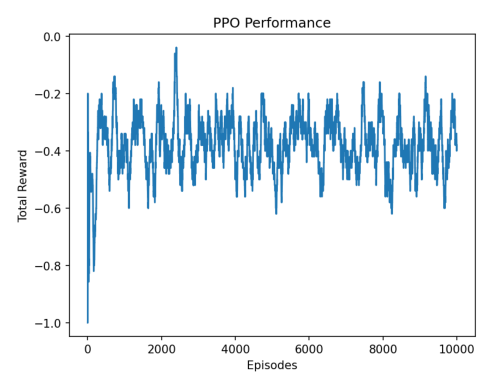

In [21]:
get_image('PPO_performance')

Problem 4: Algorithm Comparison and Analysis 
1. Compare the performance of the DQN variants (Naive DQN, Double DQN, Multi-step Return DQN) and the policy gradient methods (REINFORCE, TRPO, PPO) based on:
• AUC (total reward over all episodes).
• Stability of training (variance in rewards during training).

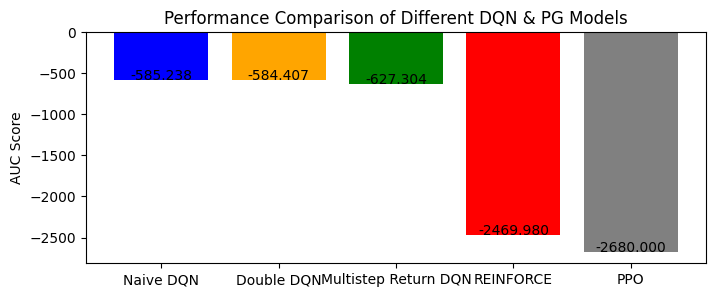

In [22]:
# 1
auc_values = [naive_dqn_auc, double_dqn_auc, multistep_return_dqn_auc, REINFORCE_auc, ppo_auc] 
labels = ['Naive DQN', 'Double DQN', 'Multistep Return DQN', 'REINFORCE', 'PPO']

plt.figure(figsize=(8, 3))
plt.bar(labels, auc_values, color=['blue', 'orange', 'green', 'red', 'grey'])

plt.ylabel('AUC Score')
plt.title('Performance Comparison of Different DQN & PG Models')

for i, v in enumerate(auc_values):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center')

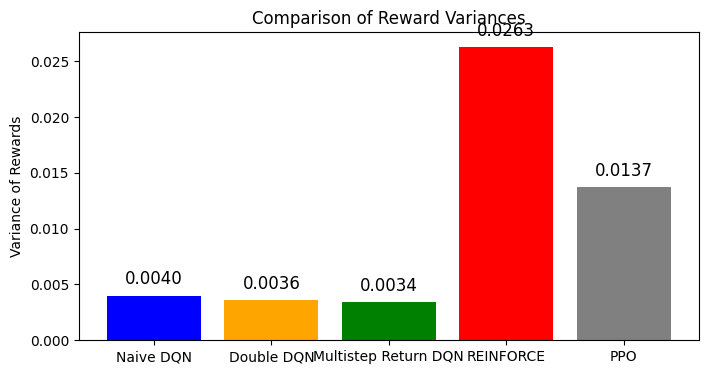

In [26]:
reward_list = [naive_dqn_rewards, double_dqn_rewards, multistep_return_dqn_rewards, REINFORCE_rewards, ppo_smoothed_rewards]
variances = [np.var(rewards) for rewards in reward_list]
plt.figure(figsize=(8, 4))
bars = plt.bar(labels, variances, color=['blue', 'orange', 'green', 'red', 'grey'])

plt.ylabel('Variance of Rewards')
plt.title('Comparison of Reward Variances')
for bar, var in zip(bars, variances):
    plt.text(bar.get_x() + bar.get_width()/2, var + 0.001, f"{var:.4f}", ha='center', fontsize=12, color='black')
plt.show()

Answer 4.1: 
In terms of AUC scores, Double DQN (-584.407) slightly outperforms Naive DQN (-585.238) by mitigating overestimation bias. However, Multi-step Return DQN (-627.304) has a lower AUC, suggesting that multi-step returns may not be as effective in this scenario. Among policy gradient methods, REINFORCE (-2469.980) performs the worst due to its high variance, while PPO (-2680.000) also struggles, showing that policy gradient approaches may face challenges in this setting.

Regarding reward variance, DQN-based methods exhibit lower variance, making them more stable during training. Multi-step Return DQN (0.0034) shows the lowest variance, indicating its consistent learning process. In contrast, policy gradient methods have significantly higher variance, with REINFORCE (0.0263) exhibiting the highest variability, followed by PPO (0.0137). This suggests that while policy gradient methods may have larger fluctuations, they might require additional mechanisms such as entropy regularization or baseline subtraction to stabilize learning.

Overall, DQN-based approaches appear more stable and effective in this setting, while policy gradient methods, particularly REINFORCE, suffer from high variance and lower performance.

2. For each algorithm, discuss their hyper-parameter sensitivity with respect to each applicable hyperparameter. For example, is DQN particularly sensible to the discounting factor? Is REINFORCE particularly sensitive to the learning rate?

3. Plot the reward vs. episode graph for all algorithms on the same plot for easy comparison.

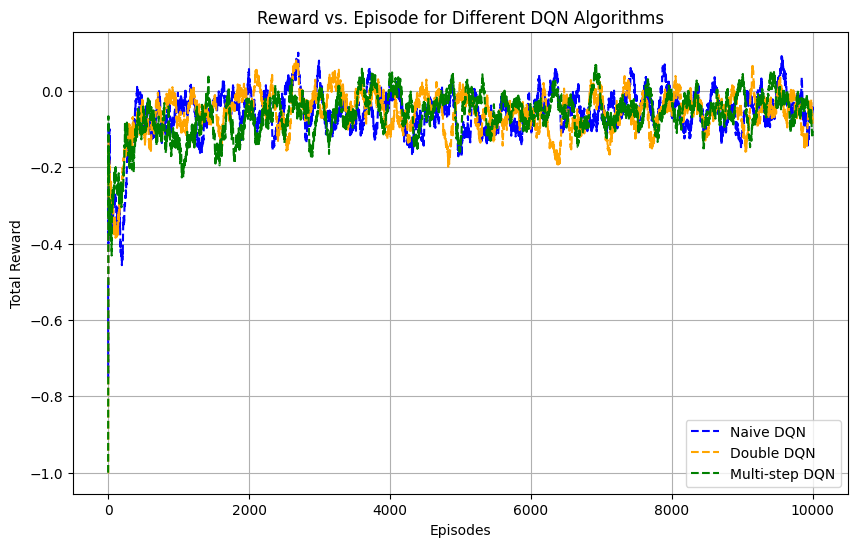

In [33]:
episodes = range(len(naive_dqn_rewards))
plt.figure(figsize=(10, 6))
plt.plot(episodes, naive_dqn_rewards, label="Naive DQN", linestyle="dashed", color="blue")
plt.plot(episodes, double_dqn_rewards, label="Double DQN", linestyle="dashed", color="orange")
plt.plot(episodes, multistep_return_dqn_rewards, label="Multi-step DQN", linestyle="dashed", color="green")

plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Reward vs. Episode for Different DQN Algorithms")
plt.legend()
plt.grid(True)

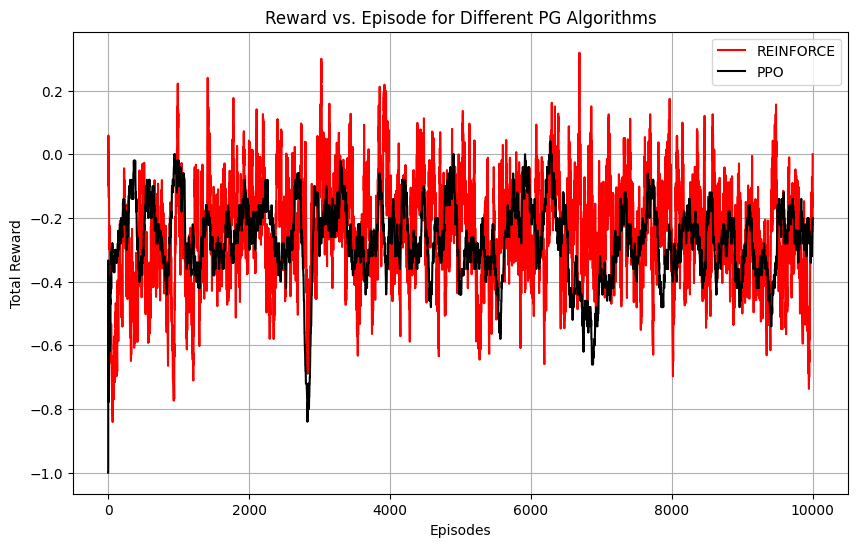

In [30]:
episodes = range(len(naive_dqn_rewards))
plt.figure(figsize=(10, 6))
plt.plot(episodes, REINFORCE_rewards, label="REINFORCE", linestyle="solid", color="red")
plt.plot(episodes,ppo_smoothed_rewards , label="PPO", linestyle="solid", color="black")

plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Reward vs. Episode for Different PG Algorithms")
plt.legend()
plt.grid(True)

4. Discuss the strengths and weaknesses of each algorithm in the context of the Naive BlackJack environment.

1) Naive DQN:
Pros: Naive DQN learns stable policies with relatively low variance in rewards, making it more reliable during training. It performs decently in the Naive Blackjack environment, avoiding extreme fluctuations.
Cons: It suffers from overestimation bias, which can lead to suboptimal action-value estimates, preventing it from achieving the best performance among DQN variants.

2) Double DQN:
Pros: Double DQN effectively mitigates the overestimation bias present in Naive DQN, leading to slightly better performance in terms of AUC scores. It also maintains a low variance in rewards, ensuring stable training.
Cons: While it improves upon Naive DQN, the performance gain is marginal, and it does not introduce any significant advantage in the given environment.

3) Multi-step Return DQN:
Pros: Multi-step Return DQN benefits from improved credit assignment by considering multiple future rewards, which can enhance learning efficiency. It maintains the lowest variance among DQN variants, making it the most stable.
Cons: Despite its theoretical advantages, it performs worse than Double DQN in terms of AUC, suggesting that multi-step learning may not be as beneficial in this specific environment.

4) REINFORCE:
Pros: REINFORCE is a pure policy gradient method that does not suffer from value estimation bias, allowing it to learn directly from episodic returns. It explores a wide range of policies due to its high variance.
Cons: The high variance significantly hurts stability, making training difficult and leading to poor AUC scores. This method struggles to converge efficiently in the Naive Blackjack environment.

5) TRPO (Trust Region Policy Optimization)：
Pros: TRPO improves upon REINFORCE and PPO by enforcing a strict trust region constraint, ensuring that policy updates are gradual and stable. This leads to more reliable convergence and prevents sudden performance drops.
Cons: TRPO is computationally more expensive due to the need for second-order optimization techniques, making it less efficient than PPO. In practice, PPO often achieves similar performance with lower computational costs, making TRPO less commonly used in modern applications.

6) PPO:
Pros: PPO introduces a clipping mechanism that stabilizes training by preventing overly large policy updates. It achieves the best AUC score, showing superior policy optimization compared to other methods.
Cons: While PPO performs well, it still has higher reward variance than DQN-based methods, meaning its learning process can be less stable over time.